In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
#import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics

plt.style.use('seaborn')
sns.set(font_scale=2)
pd.set_option('display.max_columns', 500)

In [92]:
import scipy.stats as stats

In [44]:
CATO_COLS = ['HasDetections', 'Platform', 'Census_IsVirtualDevice',
        'AVProductsInstalled', 'AVProductsEnabled', 'SMode',
        'Firewall']

In [3]:
def plot_category_percent_of_target_for_numeric(col):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    cat_percent = train[[col, 'HasDetections']].groupby(col, as_index=False).mean()
    cat_size = train[col].value_counts().reset_index(drop=False)
    cat_size.columns = [col, 'count']
    cat_percent = cat_percent.merge(cat_size, on=col, how='left')
    cat_percent['HasDetections'] = cat_percent['HasDetections'].fillna(0)
    cat_percent = cat_percent.sort_values(by='count', ascending=False)[:20]
    cat_percent[col] = cat_percent[col].astype('category')
    sns.barplot(ax=ax[0], x='HasDetections', y=col, data=cat_percent,  order=cat_percent[col])

    for i, p in enumerate(ax[0].patches):
        ax[0].annotate('{}'.format(cat_percent['count'].values[i]), (p.get_width(), p.get_y()+0.5), fontsize=20)

    ax[0].set_title('Barplot sorted by count', fontsize=20)

    sns.barplot(ax=ax[1], x='HasDetections', y=col, data=cat_percent)
    for i, p in enumerate(ax[0].patches):
        ax[1].annotate('{}'.format(cat_percent['count'].sort_index().values[i]), (0, p.get_y()+0.6), fontsize=20)
    ax[1].set_title('Barplot sorted by index', fontsize=20)

    plt.xlabel('% of HasDetections(target)')
    plt.ylabel(col)
    plt.subplots_adjust(wspace=0.5, hspace=0)
    plt.show()

def plot_kde_hist_for_numeric(col):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    sns.kdeplot(train.loc[train['HasDetections'] == 0, col], ax=ax[0], label='NoDetection(0)')
    sns.kdeplot(train.loc[train['HasDetections'] == 1, col], ax=ax[0], label='HasDetection(1)')

    train.loc[train['HasDetections'] == 0, col].hist(ax=ax[1], bins=100)
    train.loc[train['HasDetections'] == 1, col].hist(ax=ax[1], bins=100)

    plt.suptitle(col, fontsize=30)
    ax[0].set_yscale('log')
    ax[0].set_title('KDE plot')
    
    ax[1].set_title('Histogram')
    ax[1].legend(['NoDetection(0)', 'HasDetection(1)'])
    ax[1].set_yscale('log')
    plt.show()
def plot_category_percent_of_target(col):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    cat_percent = train[[col, 'HasDetections']].groupby(col, as_index=False).mean()
    cat_size = train[col].value_counts().reset_index(drop=False)
    cat_size.columns = [col, 'count']
    cat_percent = cat_percent.merge(cat_size, on=col, how='left')
    cat_percent['HasDetections'] = cat_percent['HasDetections'].fillna(0)
    cat_percent = cat_percent.sort_values(by='count', ascending=False)[:20]
    sns.barplot(ax=ax, x='HasDetections', y=col, data=cat_percent, order=cat_percent[col])

    for i, p in enumerate(ax.patches):
        ax.annotate('{}'.format(cat_percent['count'].values[i]), (p.get_width(), p.get_y()+0.5), fontsize=20)

    plt.xlabel('% of HasDetections(target)')
    plt.ylabel(col)
    plt.show()

In [384]:
train = pd.read_csv("train.csv", sep=',', engine='c', usecols=CATO_COLS)

#test_data = pd.read_csv('test.csv', iterator=True, chunksize=1000)

In [385]:
train.shape

(8921483, 7)

In [197]:
pd.set_option('display.max_rows', 100)

In [198]:
train.head()

,AVProductsInstalled,AVProductsEnabled,Platform,SMode,Firewall,Census_IsVirtualDevice,HasDetections
0,1.0,1.0,windows10,0.0,1.0,0.0,0
1,1.0,1.0,windows10,0.0,1.0,0.0,0
2,1.0,1.0,windows10,0.0,1.0,0.0,0
3,1.0,1.0,windows10,0.0,1.0,0.0,1
4,1.0,1.0,windows10,0.0,1.0,0.0,1


In [199]:
# Check the target

Text(0.5, 1.0, 'HasDetections')

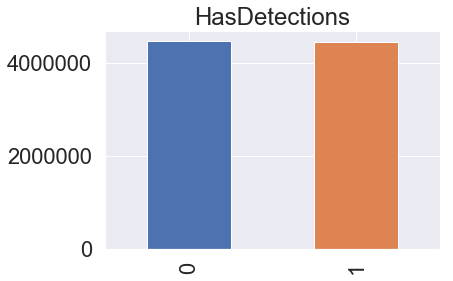

In [200]:
train['HasDetections'].value_counts().plot(kind = 'bar')
plt.title('HasDetections')

In [201]:
train.isnull().mean()

AVProductsInstalled       0.004060
AVProductsEnabled         0.004060
Platform                  0.000000
SMode                     0.060277
Firewall                  0.010239
Census_IsVirtualDevice    0.001788
HasDetections             0.000000
dtype: float64

In [202]:
# Examine null value

In [203]:
train.shape[1]

7

In [204]:
for i in range(train.shape[1]):
    print(train.iloc[:,i].name)
    print(train.iloc[:,i].unique())

AVProductsInstalled
[ 1.  2.  3.  5. nan  4.  6.  7.  0.]
AVProductsEnabled
[ 1.  2.  0.  4. nan  3.  5.]
Platform
['windows10' 'windows7' 'windows8' 'windows2016']
SMode
[ 0. nan  1.]
Firewall
[ 1.  0. nan]
Census_IsVirtualDevice
[ 0. nan  1.]
HasDetections
[0 1]


In [205]:
#1.1 AV procucts installed independent controll study

In [206]:
train.groupby('AVProductsInstalled').HasDetections.count()

AVProductsInstalled
0.0          1
1.0    6208893
2.0    2459008
3.0     208103
4.0       8757
5.0        471
6.0         28
7.0          1
Name: HasDetections, dtype: int64

In [18]:
proportion = train.groupby('AVProductsInstalled').HasDetections.sum() / train.groupby('AVProductsInstalled').HasDetections.count()

In [19]:
proportion

AVProductsInstalled
0.0    0.000000
1.0    0.548581
2.0    0.396906
3.0    0.291596
4.0    0.270755
5.0    0.265393
6.0    0.214286
7.0    1.000000
Name: HasDetections, dtype: float64

In [20]:
# Since samples of 0.0 and 7.0 are just 1, we consider not to condider the catogories

In [407]:
def numerical_analysis(col):
    temp = train[col].value_counts()
    temp = temp[temp > temp.iloc[0]//100].index
    temp_df = train[train[col].isin(temp)]
    #temp_df = temp_df.sample(1000)
    
    p = temp_df.HasDetections.mean()
    q = 1-p
    random_data = pd.Series(np.random.choice([1,0], len(temp_df),p=[p,q]), index = temp_df.index).rename('HasDetections')
    temp_df['random_data'] = random_data
    
    #temp_df.groupby(col).HasDetections.mean().plot(kind = 'bar', figsize=(20,10))
    temp_df.groupby(col)[['HasDetections', 'random_data']].mean().plot(kind = 'bar', figsize=(20,10))
    plt.title('Percent of Has detections by {}'.format(col))
    return stats.chi2_contingency( [temp_df.groupby(col).HasDetections.mean() , 
                temp_df.groupby(col).random_data.mean()])

(1.823861045940895, 0.17685437243244795, 1, array([[0.4591525 , 0.38190576],
        [0.54616578, 0.45428013]]))

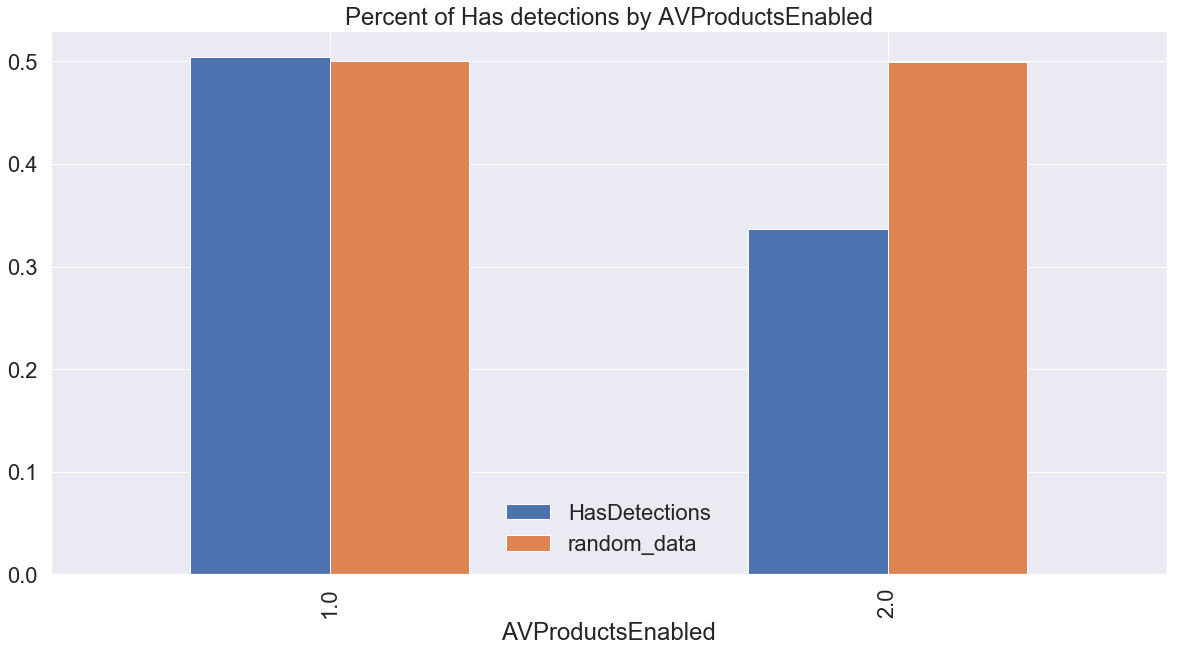

In [408]:
numerical_analysis(CATO_COLS[4])

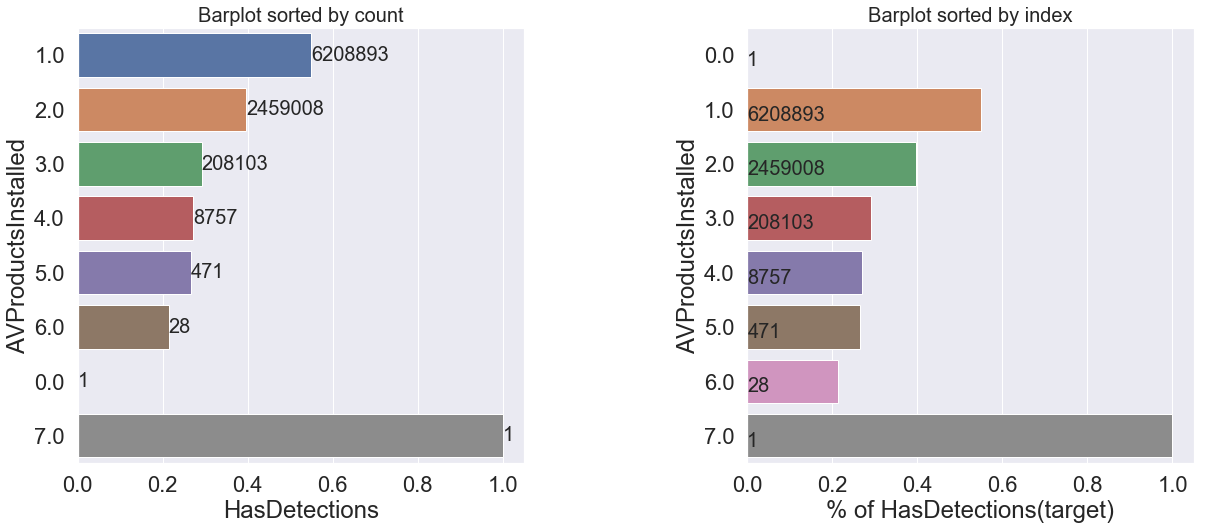

In [24]:
plot_category_percent_of_target_for_numeric('AVProductsInstalled')

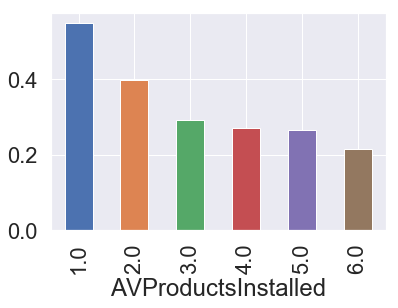

In [25]:
proportion.iloc[1:-1].plot('bar')

In [27]:
dflst = []
for i in range(1,7):
    dflst +=[train[train.AVProductsInstalled == i]['HasDetections']]

In [28]:
# dflst to make test 

In [29]:
#Test

In [30]:
# 1.2 Platform

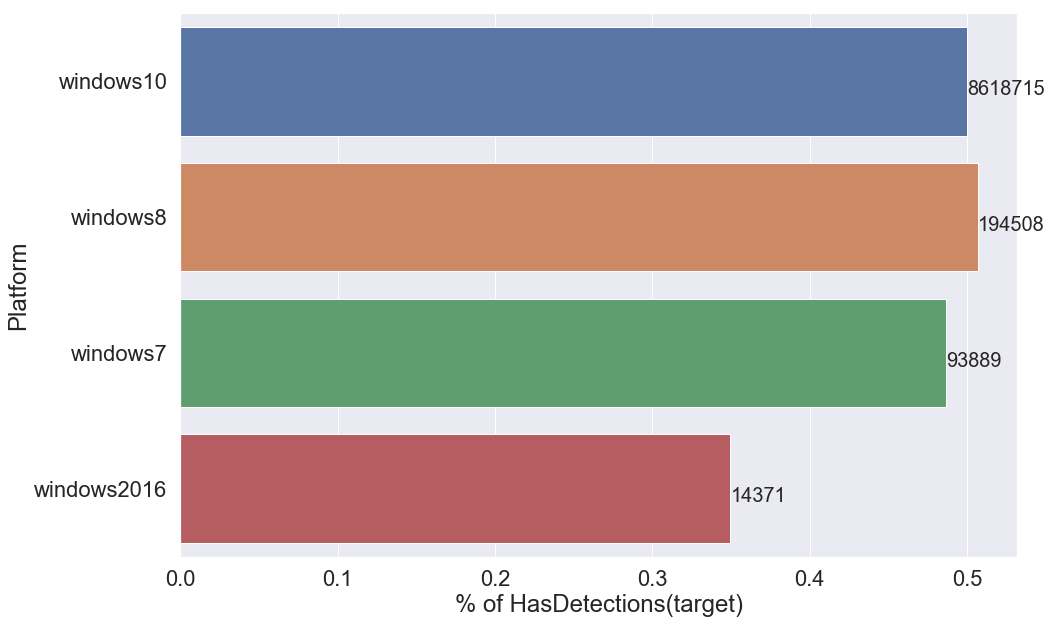

In [31]:
plot_category_percent_of_target('Platform')

In [32]:
# proportion test for ANOVA

In [33]:
#1.3 Census_IsVirtualDevice

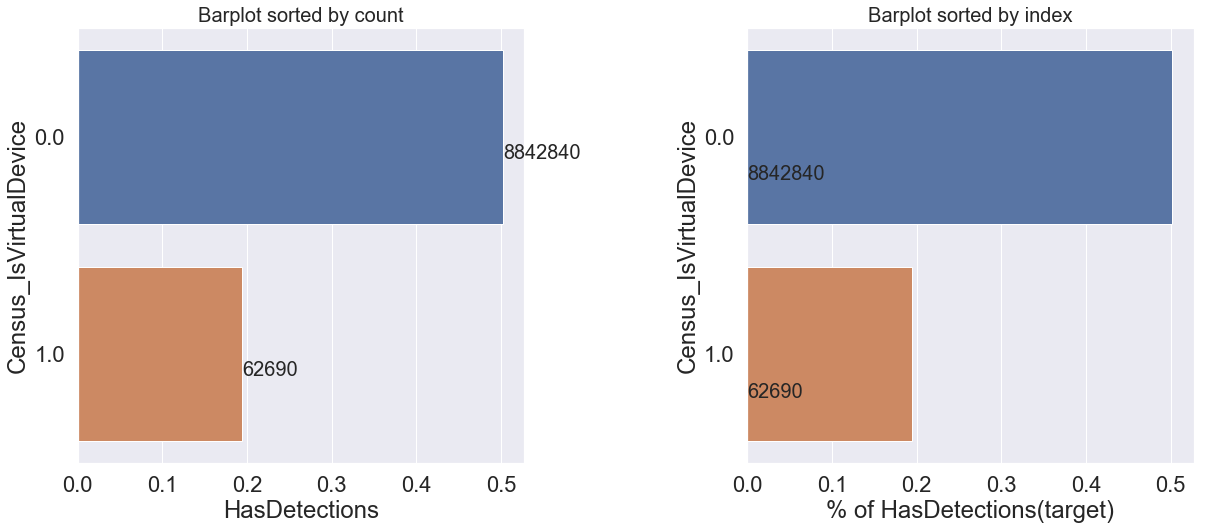

In [34]:
plot_category_percent_of_target_for_numeric('Census_IsVirtualDevice')

In [35]:
#1.4 AVProductsEnabled

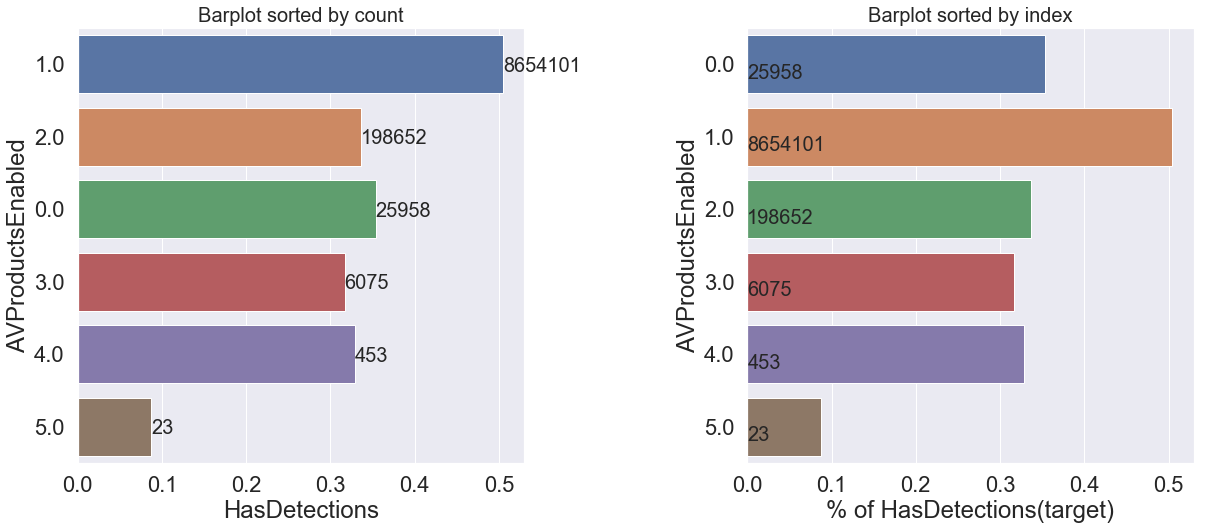

In [36]:
plot_category_percent_of_target_for_numeric('AVProductsEnabled')

In [37]:
#1.5 SMode

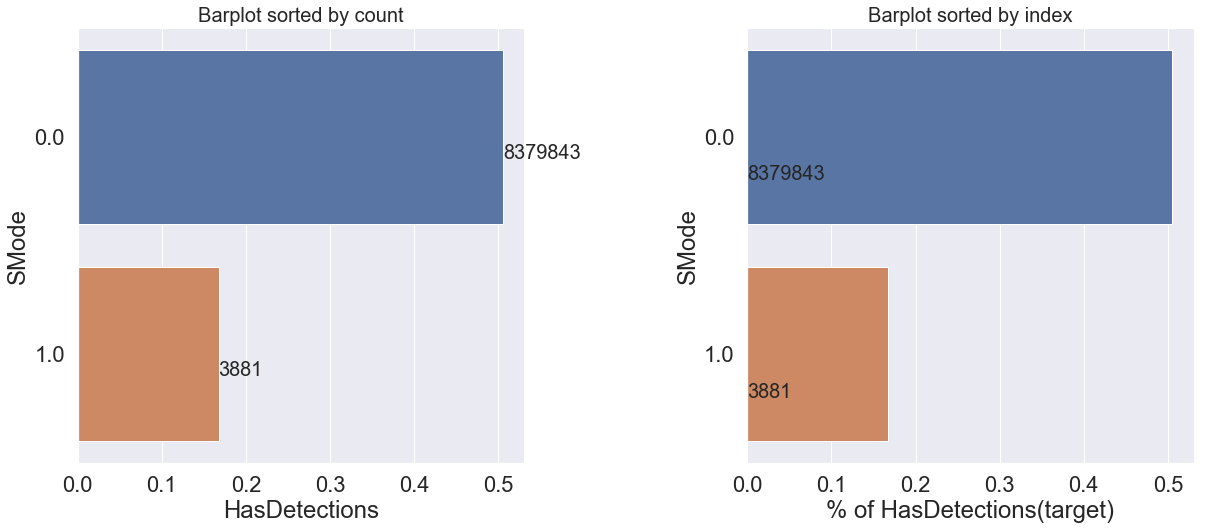

In [38]:
plot_category_percent_of_target_for_numeric('SMode')

In [40]:
#1.6 Firewall

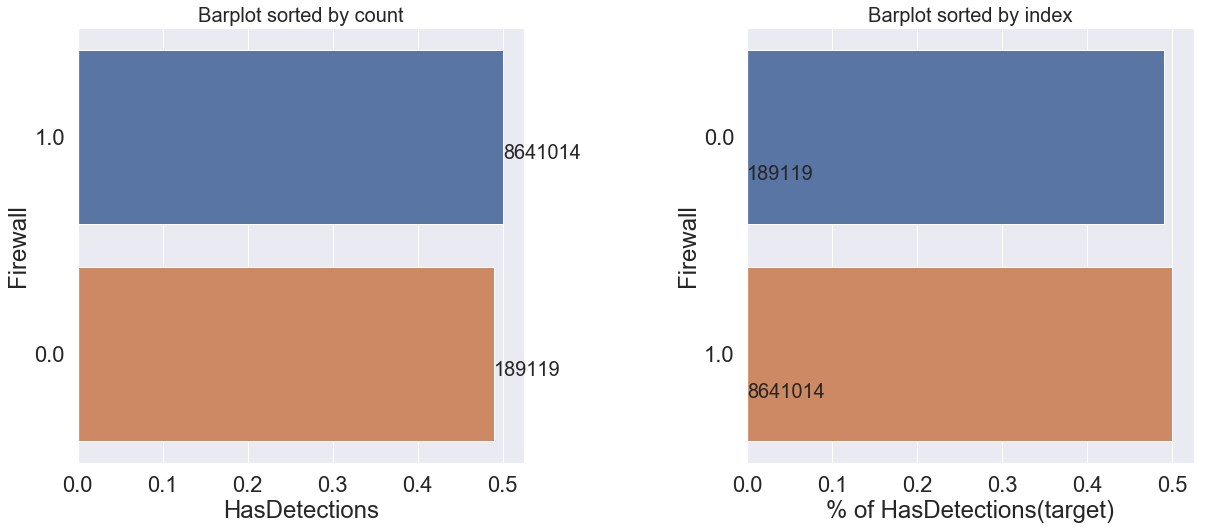

In [41]:
plot_category_percent_of_target_for_numeric('Firewall')

In [383]:
del train
gc.collect()

2471

In [371]:
NUMER_COLS = [
    'HasDetections',
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalBatteryNumberOfCharges'
]

In [372]:
train = pd.read_csv("train.csv", sep=',', engine='c', usecols=NUMER_COLS)

In [373]:
train.head()

,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_TotalPhysicalRAM,Census_InternalBatteryNumberOfCharges,HasDetections
0,4.0,476940.0,4096.0,4.294967e+09,0
1,4.0,476940.0,4096.0,1.000000e+00,0
2,4.0,114473.0,4096.0,4.294967e+09,0
3,4.0,238475.0,4096.0,4.294967e+09,1
4,4.0,476940.0,6144.0,0.000000e+00,1


In [374]:
p = train.HasDetections.mean()
q = 1-p

In [375]:
copy = train.copy()

In [349]:
random_data = pd.Series(np.random.choice([1,0], len(copy),p=[p,q]))
copy['random_data'] = random_data

In [378]:
def numerical_analysis(col):
    temp = train[col].value_counts()
    #temp = temp[temp > temp.iloc[0]//100].index
    temp_df = train[train[col].isin(temp)]
    #temp_df = temp_df.sample(1000)
    
    p = temp_df.HasDetections.mean()
    q = 1-p
    random_data = pd.Series(np.random.choice([1,0], len(temp_df),p=[p,q]), index = temp_df.index).rename('HasDetections')
    temp_df['random_data'] = random_data
    
    #temp_df.groupby(col).HasDetections.mean().plot(kind = 'bar', figsize=(20,10))
    temp_df.groupby(col)[['HasDetections', 'random_data']].mean().plot(kind = 'bar', figsize=(20,10))
    plt.title('Percent of Has detections by {}'.format(col))
    return stats.chi2_contingency( [temp_df.groupby(col).HasDetections.mean() , 
                temp_df.groupby(col).random_data.mean()])

(0.06750094993234652,
 0.9999385297463792,
 5,
 array([[0.39530627, 0.47709219, 0.50084465, 0.53122495, 0.52406555,
         0.54039654],
        [0.39973564, 0.48243797, 0.50645657, 0.53717728, 0.52993766,
         0.54645164]]))

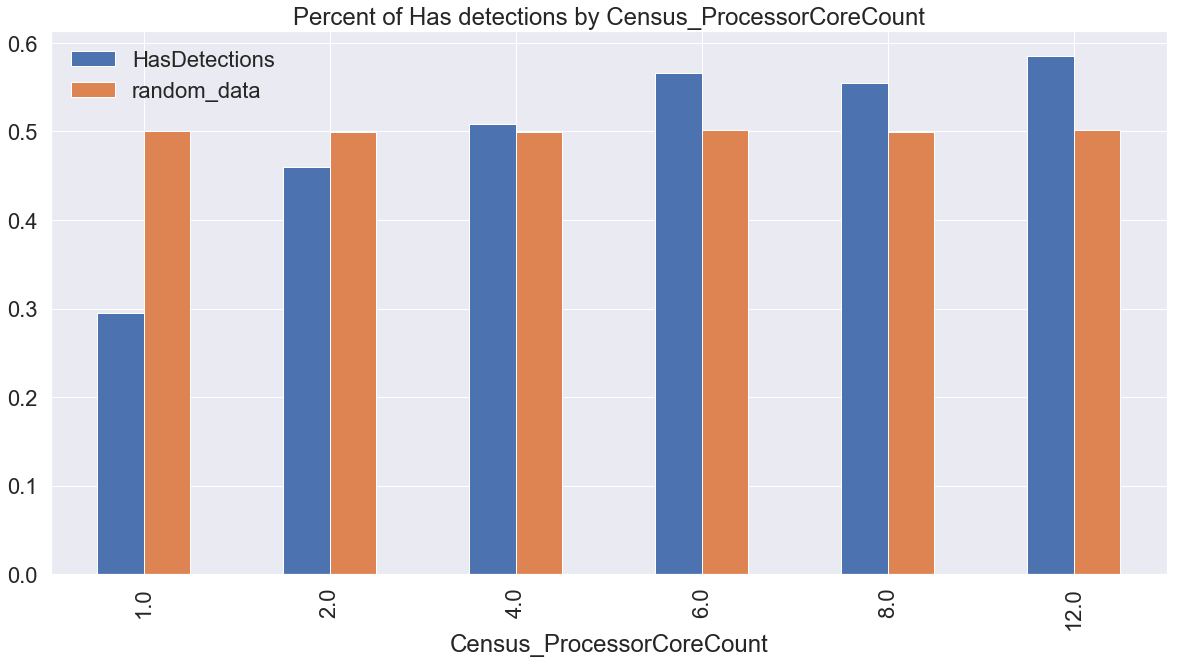

In [379]:
numerical_analysis(NUMER_COLS[1])

(0.10710899564162389,
 0.9999999999999984,
 16,
 array([[0.40145157, 0.45055787, 0.43464758, 0.4094634 , 0.50867144,
         0.50039333, 0.44352308, 0.52383925, 0.47880899, 0.50193901,
         0.45742062, 0.48722359, 0.5008581 , 0.47276435, 0.49066275,
         0.5048564 , 0.50902661],
        [0.42696024, 0.4791868 , 0.46226556, 0.43548115, 0.54099297,
         0.53218886, 0.47170502, 0.55712456, 0.50923303, 0.53383276,
         0.48648561, 0.5181823 , 0.53268317, 0.5028043 , 0.52183999,
         0.53693551, 0.5413707 ]]))

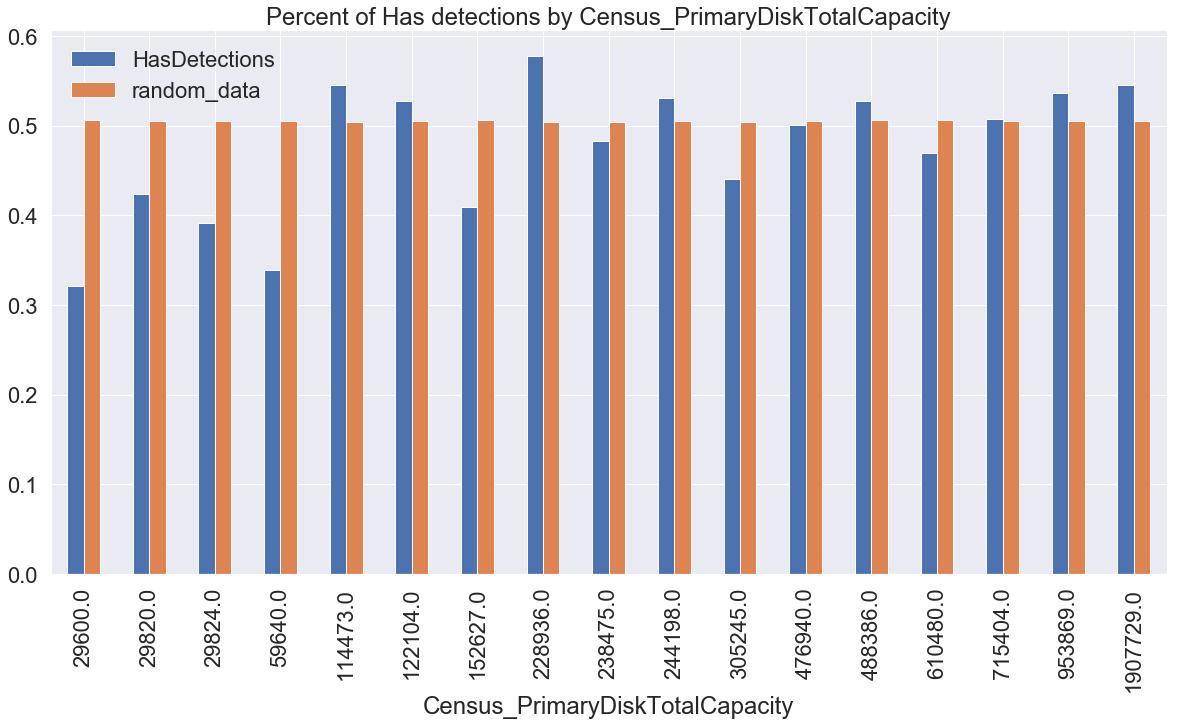

In [380]:
numerical_analysis(NUMER_COLS[2])

(0.11056865817861566,
 0.9999996276023402,
 8,
 array([[0.37031006, 0.44596   , 0.4568268 , 0.48966709, 0.50142111,
         0.51002435, 0.52288973, 0.52534875, 0.5170248 ],
        [0.38446634, 0.46300823, 0.47429045, 0.50838616, 0.52058952,
         0.52952165, 0.54287884, 0.54543187, 0.53678971]]))

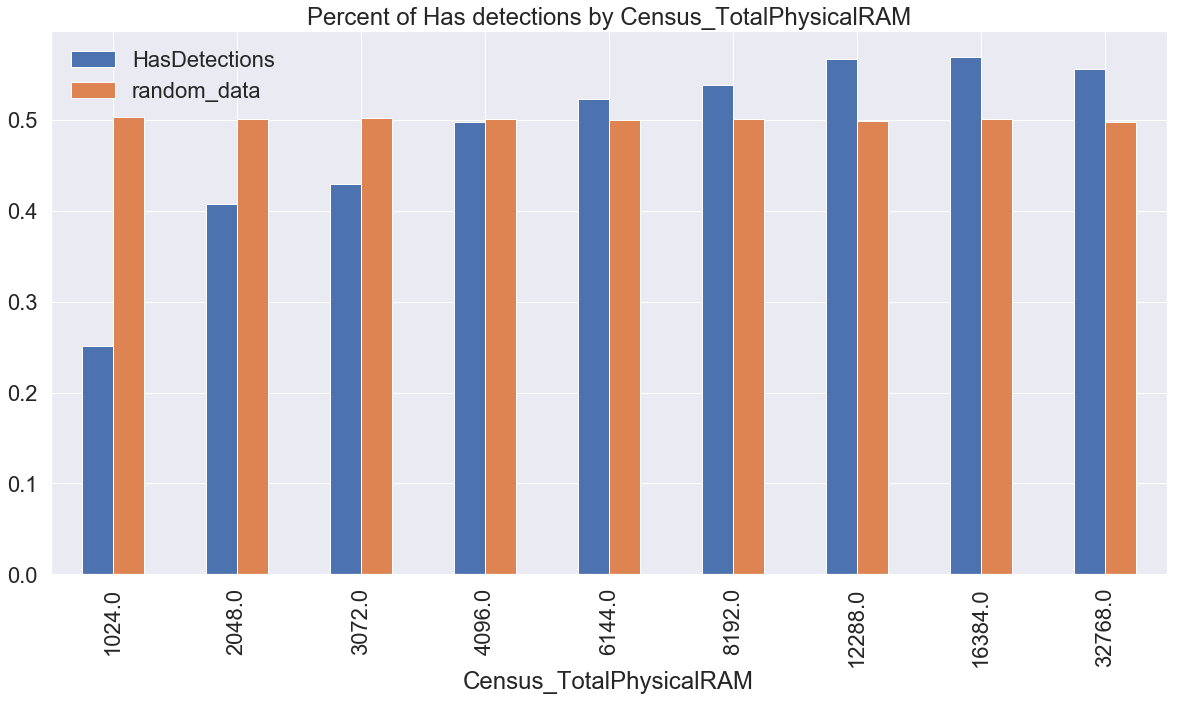

In [381]:
numerical_analysis(NUMER_COLS[3])

(0.005314161642895632,
 0.9973464460933406,
 2,
 array([[0.48744525, 0.44864622, 0.49679881],
        [0.51195099, 0.47120139, 0.52177478]]))

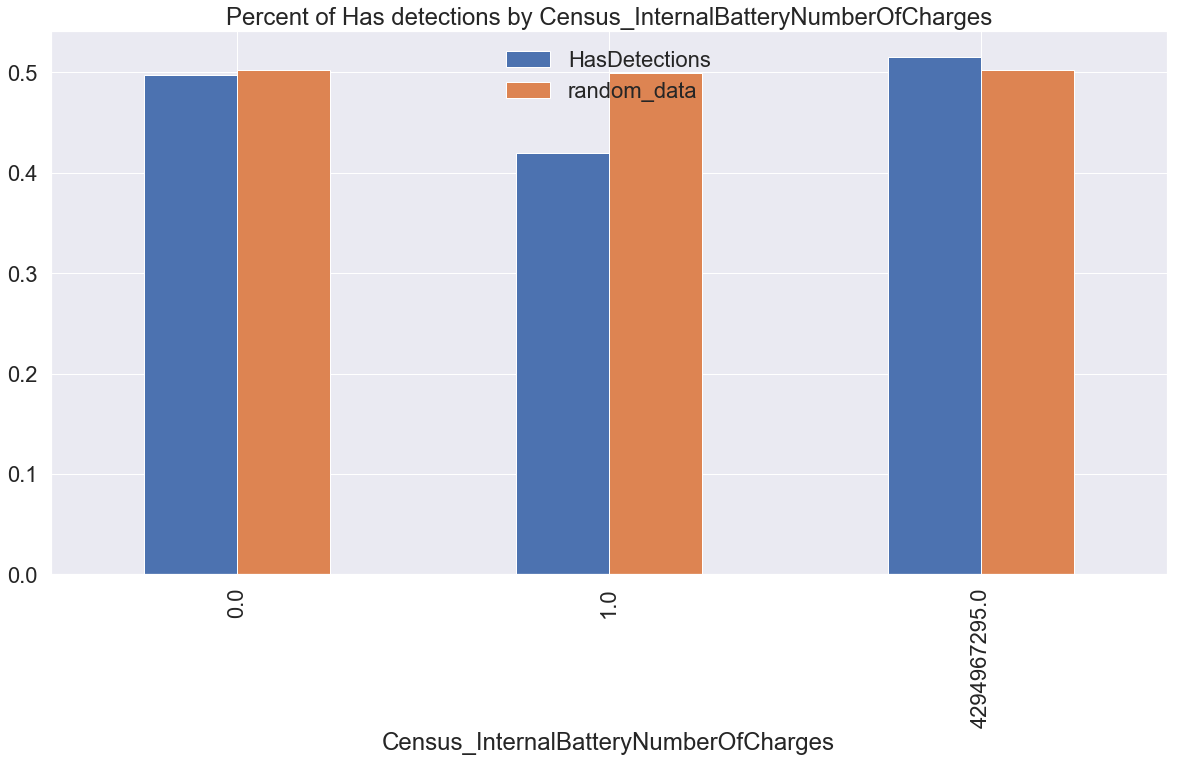

In [382]:
numerical_analysis(NUMER_COLS[4])